# PART ONE

• **DOMAIN**: Digital content management

• **CONTEXT**: Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles, etc. are written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to create a classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.

• **DATA DESCRIPTION**: Over 600,000 posts from more than 19 thousand bloggers The Blog Authorship Corpus consists of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,288 posts and over 140 million words - or approximately 35 posts and 7250 words per person. Each blog is presented as a separate file, the name of which indicates a blogger id# and the blogger’s self-provided gender, age, industry, and astrological sign. (All are labelled for gender and age but for many, industry and/or sign is marked as unknown.) All bloggers included in the corpus fall into one of three age groups:

• 8240 "10s" blogs (ages 13-17), <BR>
• 8086 "20s" blogs(ages 23-27) and <br>
• 2994 "30s" blogs (ages 33-47) <br>
• For each age group, there is an equal number of male and female bloggers. Each blog in the corpus includes at least 200 occurrences of
common English words. All formatting has been stripped with two exceptions. Individual posts within a single blogger are separated by the
date of the following post and links within a post are denoted by the label url link.
    
• **PROJECT OBJECTIVE**: To build a NLP classifier which can use input text parameters to determine the label/s of the blog. Specific to this case study, you can consider the text of the blog: ‘text’ feature as independent variable and ‘topic’ as dependent variable.

## 1. Read and Analyse Dataset. 
A. Clearly write outcome of data analysis<br> 
B. Clean the Structured Data <br> 
i. Missing value analysis and imputation.<br> 
ii. Eliminate Non-English textual data<br> 
Hint: Refer ‘langdetect’ library to detect language of the input text)

In [4]:
# importing libraries
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manvi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
import gc # automatic garbage collector 
gc.enable

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import re
import spacy
import string
import seaborn as sns


sns.set(rc={'figure.figsize':(15,16)})
sns.set_theme(style="darkgrid")

In [8]:
# unzip the data
from zipfile import ZipFile
with ZipFile('blogs.zip') as z:
    z.extractall()

In [9]:
# load dataset 
data = pd.read_csv('blogtext.csv', index_col = False)

In [11]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [13]:
# shape of the data
data.shape

(681284, 7)

In [16]:
# dropping the columns 'id' and 'date'
data.drop(labels=['id','date'], axis=1, inplace=True)

In [18]:
data.shape

(681284, 5)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   gender  681284 non-null  object
 1   age     681284 non-null  int64 
 2   topic   681284 non-null  object
 3   sign    681284 non-null  object
 4   text    681284 non-null  object
dtypes: int64(1), object(4)
memory usage: 26.0+ MB


### Preprocessing
Some of the common text preprocessing / cleaning steps are:

- [ ] remove unwanted space 
- [ ] remove unwanted characters / remove Punctuation
- [ ] remove Stopwords 
- [ ] convert text to lowercase

In [20]:
## truncated dataset to start on rapid protyping to preprocessing 
df_trc = data[["text"]]

In [21]:
df_trc[:5]

,text
0,"Info has been found (+/- 100 pages,..."
1,These are the team members: Drewe...
2,In het kader van kernfusie op aarde...
3,testing!!! testing!!!
4,Thanks to Yahoo!'s Toolbar I can ...


In [22]:
pd.options.mode.chained_assignment = None
df_trc['text'] = df_trc[['text']]
# change the datatype of 'text' column to string
df_trc['text'] = df_trc['text'].astype(str)

### Lower Casing
Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.

This is more helpful for text featurization techniques like frequency, tfidf as it helps to combine the same words together thereby reducing the duplication and get correct counts / tfidf values.

This may not be helpful when we do tasks like Part of Speech tagging (where proper casing gives some information about Nouns and so on) and Sentiment Analysis (where upper casing refers to anger and so on)

By default, lower casing is done my most of the modern day vecotirzers and tokenizers like sklearn TfidfVectorizer and Keras Tokenizer. So we need to set them to false as needed depending on our use case.

In [26]:
df_trc['text_lowercase'] = df_trc['text'].str.lower()
df_trc.head()

,text,text_lowercase
0,"Info has been found (+/- 100 pages,...","info has been found (+/- 100 pages,..."
1,These are the team members: Drewe...,these are the team members: drewe...
2,In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde...
3,testing!!! testing!!!,testing!!! testing!!!
4,Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo!'s toolbar i can ...


### Removal of Punctuations
One another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat 'hurray' and 'hurray!' in the same way.

We also need to carefully choose the list of punctuations to exclude depending on the use case. For example, the string.punctuation in python contains the following punctuation symbols

!"#$%&'()*+,-./:;<=>?@[\]^_{|}~`

We can add or remove more punctuations as per our need.

In [27]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('','',PUNCT_TO_REMOVE))


### Removal of stopwords

Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis. In cases like Part of Speech tagging, we should not remove them as provide very valuable information about the POS.

These stopword lists are already compiled for different languages and we can safely use them. For example, the stopword list for english language from the nltk package can be seen below.

In [28]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [29]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

> Pipeliining all the above steps :

In [31]:
# Pipeline the pre-processing 

def clean_text(text):
    text = text.strip()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = text.lower()
    return text
data["text"] = data["text"].map(lambda text : clean_text(text))

In [33]:
gc.collect()

data.head()

,gender,age,topic,sign,text
0,male,15,Student,Leo,info found 100 pages 45 mb pdf files now wait ...
1,male,15,Student,Leo,these team members drewes van der laag urllink...
2,male,15,Student,Leo,in het kader van kernfusie op aarde maak je ei...
3,male,15,Student,Leo,testing testing
4,male,33,InvestmentBanking,Aquarius,thanks yahoos toolbar i capture urls popupswhi...


## EDA 


After cleaning the text, let's have some idea about the dataset 

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   gender  681284 non-null  object
 1   age     681284 non-null  int64 
 2   topic   681284 non-null  object
 3   sign    681284 non-null  object
 4   text    681284 non-null  object
dtypes: int64(1), object(4)
memory usage: 26.0+ MB


In [36]:
pd.set_option('display.max_colwidth', 50)
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
gender,male,male,male,male,male,male,male,male,male,male
age,15,15,15,15,33,33,33,33,33,33
topic,Student,Student,Student,Student,InvestmentBanking,InvestmentBanking,InvestmentBanking,InvestmentBanking,InvestmentBanking,InvestmentBanking
sign,Leo,Leo,Leo,Leo,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius,Aquarius
text,info found 100 pages 45 mb pdf files now wait ...,these team members drewes van der laag urllink...,in het kader van kernfusie op aarde maak je ei...,testing testing,thanks yahoos toolbar i capture urls popupswhi...,i interesting conversation dad morning we talk...,somehow cocacola way summing things well in ea...,if anything korea country extremes everything ...,take read news article urllink joongang ilbo n...,i surf english news sites lot looking tidbits ...


In [38]:
data.isnull().any().any() 

# ## there are no null/missing values 

False

In [39]:
data.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
age,681284.0,23.932326,7.786009,13.0,17.0,24.0,26.0,48.0


In [41]:
data.age.value_counts()

17    80859
24    80071
23    72889
16    72708
25    67051
26    55312
27    46124
15    41767
14    27400
34    21347
33    17584
35    17462
36    14229
13    13133
37     9317
38     7545
39     5556
40     5016
45     4482
43     4230
41     3738
48     3572
42     2908
46     2733
47     2207
44     2044
Name: age, dtype: int64

In [42]:
data.describe(include = [np.object]).T

C:\Users\manvi\AppData\Local\Temp\ipykernel_10952\2343557204.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.describe(include = [np.object]).T


,count,unique,top,freq
gender,681284,2,male,345193
topic,681284,40,indUnk,251015
sign,681284,12,Cancer,65048
text,681284,607983,,3390


In [44]:
## let's do some memory analysis for dataframe and try reducing whenever possible

orignal_mem = data.memory_usage(deep=True)

In [45]:
orignal_mem

Index           128
gender     42230506
age         5450272
topic      44161324
sign       43126036
text      589262762
dtype: int64

In [46]:
data.gender.value_counts()

male      345193
female    336091
Name: gender, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

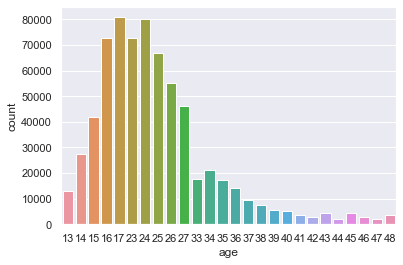

In [48]:
sns.countplot(x="age", data=data)

<AxesSubplot:xlabel='age', ylabel='count'>

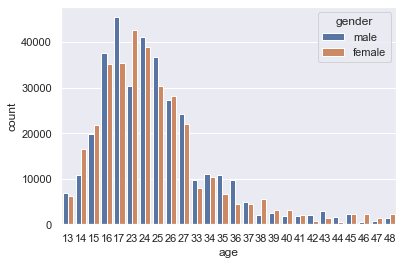

In [49]:
sns.countplot(x="age", hue="gender", data=data)

<AxesSubplot:xlabel='topic', ylabel='count'>

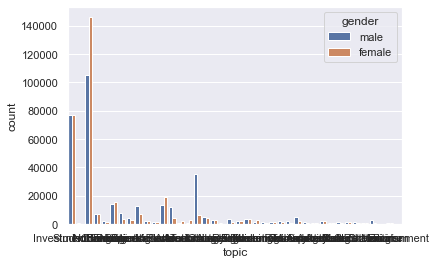

In [51]:
sns.countplot(x="topic", hue="gender", data=data)

### Merge labels for multi-label classification problem 

       Label columns to merge : ["gender", "age", "topic", "sign"]
       
       
       Reduce dataset to 
           dataset --> dataset[text, labels]

In [52]:
data["age"] = data["age"].astype(str)
data["labels"] = data.apply(lambda col :
                            [col["gender"],col["age"],col["topic"],col["sign"]],axis =1)

In [54]:
data.drop(columns=["gender","age","sign","topic"],axis =1, inplace = True)
gc.collect()

0

In [55]:
data.head(10)

,text,labels
0,info found 100 pages 45 mb pdf files now wait ...,"[male, 15, Student, Leo]"
1,these team members drewes van der laag urllink...,"[male, 15, Student, Leo]"
2,in het kader van kernfusie op aarde maak je ei...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoos toolbar i capture urls popupswhi...,"[male, 33, InvestmentBanking, Aquarius]"
5,i interesting conversation dad morning we talk...,"[male, 33, InvestmentBanking, Aquarius]"
6,somehow cocacola way summing things well in ea...,"[male, 33, InvestmentBanking, Aquarius]"
7,if anything korea country extremes everything ...,"[male, 33, InvestmentBanking, Aquarius]"
8,take read news article urllink joongang ilbo n...,"[male, 33, InvestmentBanking, Aquarius]"
9,i surf english news sites lot looking tidbits ...,"[male, 33, InvestmentBanking, Aquarius]"


### Create train and test dataset

    Let's create a simple train and test dataset then create a cross validation too

In [57]:
from sklearn.model_selection import train_test_split

X = data.text
y = data.labels

X_train, X_test, y_train, y_test =train_test_split(X,y, random_state=42,
                                                   test_size = 0.1,
                                                  shuffle = True)

In [58]:
print("shape of training set :", X_train.shape)
print("shape of test set :", X_test.shape)

# gc.collect()

shape of training set : (613155,)
shape of test set : (68129,)


### Vectorizing the features 

    1. Bag of words 
    2. TfIDF
    
    
    
  #### Counte Vectorizer on BoW 

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                      ngram_range=(1, 3), stop_words = 'english')

# inspired by : https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle
# # Fitting Count Vectorizer to both training and test sets (semi-supervised learning)

corpus = list(X_train)+list(X_test)
# gc.collect()


In [ ]:
ctv.fit(corpus)

In [ ]:
# gc.collect()
xtrain_ctv = ctv.transform(X_train)

In [ ]:
# gc.collect()
xtest_ctv = ctv.transform(X_test)

In [ ]:
print(len(ctv.vocabulary_))

In [ ]:
ctv.get_feature_names()[:10]

### Create a dictionary to get the count of every label 
    The key will be label name and value will be the total count of the label. Check below image for reference

In [ ]:
label_counts=dict()

for labels in data_orignal.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1
        
label_counts


# gc.collect()

### Transform the labels


    Transform between iterable of iterables and a multilabel format
    
    As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose, it is convenient to use MultiLabelBinarizer from sklearn a. Convert your train and test labels using MultiLabelBinarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Transform between iterable of iterables and a multilabel format
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))


y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [ ]:
y_train

### Multi-Label Classification Techniques

    Most traditional learning algorithms are developed for single-label classification problems. Therefore a lot of approaches in the literature transform the multi-label problem into multiple single-label problems, so that the existing single-label algorithms can be used.

### Accuracy metric 


Before diving into preparing models , let's settle with Metrics to measure prediction score

        1. Accuracy score
        2. F1 Score
        3. Average precision score : 
            3.1 Macro averaged precision: calculate precision for all classes
                individually and then average them
            3.2 Micro averaged precision: calculate class wise true positive and false
                positive and then use that to calculate overall precision
        4. Average recall score


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

### 1. OneVsRest

    Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).
    
    In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.
    
    The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'),
                    n_jobs=-1)),])
LogReg_pipeline.fit(xtrain_ctv, y_train)

Y_predicted_oneVsRest = LogReg_pipeline.predict(xtest_ctv)



##### To Try :
 1. Bianry Relevance
 2. Classifier Chains
 3. Label Powerset 
 4. Adapted Algorithm

In [ ]:
display_metrics_micro(y_test,Y_predicted_oneVsRest)

In [ ]:
display_metrics_macro(y_test,Y_predicted_oneVsRest)

In [ ]:
display_metrics_weighted(y_test,Y_predicted_oneVsRest)

### Let's check for any 5 inputs and there predicted labels
Print true label and predicted label for any five examples

In [ ]:
import random 

def print_predicted(y_predicted, y_test = y_test , n = 5):
    j = []
    for i in range(n):
        j.append(random.randint(0, len(y_test)))
    print(j)
                 
    for k in j:
        print(binarizer.inverse_transform(y_predicted)[k])
        print(binarizer.inverse_transform(y_test)[k])
        print("=================x==================x================x==========")

In [ ]:
print_predicted(y_predicted=Y_predicted_oneVsRest,y_test=y_test, n= 10)

In [ ]:
print("-----------------------------EndofKernal----------------------------------------")

# PART-B

• **DOMAIN:** Customer support

• **CONTEXT**: Great Learning has a an academic support department which receives numerous support requests every day throughout the year.Teams are spread across geographies and try to provide support round the year. Sometimes there are circumstances where due to heavy workload certain request resolutions are delayed, impacting company’s business. Some of the requests are very generic where a proper resolution procedure delivered to the user can solve the problem. Company is looking forward to design an automation which can interact with the user, understand the problem and display the resolution procedure [ if found as a generic request ] or redirect the request to an actual human support executive if the request is complex or not in it’s database.

• **DATA DESCRIPTION**: A sample corpus is attached for your reference. Please enhance/add more data to the corpus using your linguistics skills.

• **PROJECT OBJECTIVE**: Design a python based interactive semi - rule based chatbot which can do the following:
1. Start chat session with greetings and ask what the user is looking for. [5 Marks]
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus. [10 Marks]
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it. [5 Marks]
Hint: There are a lot of techniques using which one can clean and prepare the data which can be used to train a ML/DL classifier. Hence, it might
require you to experiment, research, self learn and implement the above classifier. There might be many iterations between hand building the
corpus and designing the best fit text classifier. As the quality and quantity of corpus increases the model’s performance i.e. ability to answer
right questions also increases.
Reference: https://www.mygreatlearning.com/blog/basics-of-building-an-artificial-intelligence-chatbot/

• **Evaluation**: Evaluator will use linguistics to twist and turn sentences to ask questions on the topics described in DATA DESCRIPTION and check if
the bot is giving relevant replies.

In [1]:
# import libraries
import numpy as np
import nltk
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def tokenize(sentence):
    """
    split sentence into array of words/tokens
    a token can be a word or punctuation character, or number
    """
    return nltk.word_tokenize(sentence)


def stem(word):
    """
    stemming = find the root form of the word
    examples:
    words = ["organize", "organizes", "organizing"]
    words = [stem(w) for w in words]
    -> ["organ", "organ", "organ"]
    """
    return stemmer.stem(word.lower())


def bag_of_words(tokenized_sentence, words):
    """
    return bag of words array:
    1 for each known word that exists in the sentence, 0 otherwise
    example:
    sentence = ["hello", "how", "are", "you"]
    words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
    bog   = [  0 ,    1 ,    0 ,   1 ,    0 ,    0 ,      0]
    """
    # stem each word
    sentence_words = [stem(word) for word in tokenized_sentence]
    # initialize bag with 0 for each word
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import torch
import torch.nn as nn


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

In [3]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# from nltk_utils import bag_of_words, tokenize, stem
# from model import NeuralNet

with open('GL Bot.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')


128 patterns
8 tags: ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
154 unique stemmed words: ['a', 'abl', 'access', 'activ', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyon', 'are', 'artifici', 'backward', 'bad', 'bag', 'batch', 'bay', 'belong', 'best', 'blend', 'bloodi', 'boost', 'bot', 'buddi', 'classif', 'contact', 'creat', 'cross', 'cya', 'day', 'deep', 'did', 'diffult', 'do', 'ensembl', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodby', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imput', 'in', 'intellig', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learn', 'learner', 'leav', 'link', 'listen', 'logist', 'lot', 'machin', 'me', 'ml', 'my', 'naiv', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympu', 'olypu', 'on', 'onlin', 'oper', 'opert', 'otim', 'paramet', 'piec', 'pleas', 'pm', 'problem', 'propag', 'random', 'regre

In [4]:
import random
import json

import torch

# from model import NeuralNet
# from nltk_utils import bag_of_words, tokenize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('GL Bot.json', 'r') as json_data:
    intents = json.load(json_data)

FILE = "data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = "Pari"
print("Let's chat! (type 'quit' to exit)")
while True:
    sentence = input("You: ")
    if sentence == "quit":
        break

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
    else:
        print(f"{bot_name}: I do not understand...")

Let's chat! (type 'quit' to exit)
You: Hi
Pari: Hello! how can i help you ?
You: what is your name
Pari: I am your virtual learning assistant
You: is anyone there
Pari: Hello! how can i help you ?
You: olympus
Pari: Link: Olympus wiki
You: explain about deep learning
Pari: Link: Neural Nets wiki
You: idiot
Pari: I do not understand...
You: jerk
Pari: Please use respectful words
You: waste bot
Pari: Tarnsferring the request to your PM
You: you are not helping me
Pari: Link: Olympus wiki
You: bye
Pari: I do not understand...
You: then understand
Pari: Link: Neural Nets wiki
You: quit
